In [1]:
import pandas as pd
import sqlite3
database_path = 'olist.db'

def load_rfm_data(database_path):
    """Charge les données RFM et satisfaction depuis la base de données."""
    connection = sqlite3.connect(database_path)

    # Récupérer les données RFM
    query_rfm = """
    SELECT 
        o.customer_id,
        CAST((JULIANDAY((SELECT MAX(order_purchase_timestamp) FROM orders)) 
              - JULIANDAY(MAX(o.order_purchase_timestamp))) AS INTEGER) AS recency,
        COUNT(o.order_id) AS frequency,
        SUM(oi.price) AS monetary
    FROM 
        orders o
    JOIN 
        order_items oi ON o.order_id = oi.order_id
    WHERE 
        o.order_status = 'delivered'
    GROUP BY 
        o.customer_id;
    """
    rfm_data = pd.read_sql(query_rfm, connection)

    # Récupérer les scores de satisfaction
    query_reviews = """
    SELECT o.customer_id, AVG(r.review_score) AS satisfaction
    FROM orders o
    JOIN order_reviews r ON o.order_id = r.order_id
    GROUP BY o.customer_id;
    """
    reviews_data = pd.read_sql(query_reviews, connection)
    connection.close()

    # Fusionner RFM et satisfaction
    rfm_data = pd.merge(rfm_data, reviews_data, on='customer_id', how='left')

    # Gérer les valeurs manquantes dans satisfaction
    rfm_data['satisfaction'] = rfm_data['satisfaction'].fillna(rfm_data['satisfaction'].mean())

    return rfm_data

In [3]:
from sklearn.preprocessing import StandardScaler

def standardize_data(data, columns_to_scale):
    """Standardise les colonnes spécifiées dans les données."""
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data[columns_to_scale])
    return scaled_data, scaler

In [5]:
from sklearn.cluster import KMeans

def apply_kmeans(data, n_clusters=4, random_state=42, scaler=None):
    """
    Applique K-Means sur les données standardisées.
    Si un scaler est fourni, les données sont standardisées avant clustering.
    """
    if scaler:
        data = scaler.transform(data)

    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    clusters = kmeans.fit_predict(data)

    return clusters, kmeans

In [7]:
def summarize_clusters(data, cluster_column='Cluster'):
    """Génère un résumé statistique des clusters."""
    summary = data.groupby(cluster_column).agg({
        'recency': 'mean',
        'frequency': 'mean',
        'monetary': 'mean',
        'satisfaction': 'mean',
        'customer_id': 'count'
    }).rename(columns={'customer_id': 'count'})

    return summary

In [9]:
def compare_clusters(old_data, new_data, cluster_column='Cluster'):
    """
    Compare les clusters entre deux périodes.
    Retourne un résumé des changements et une matrice de transition.
    """
    comparison = pd.merge(
        old_data[['customer_id', cluster_column]],
        new_data[['customer_id', cluster_column]],
        on='customer_id',
        suffixes=('_old', '_new')
    )
    comparison['Changed'] = comparison[f'{cluster_column}_old'] != comparison[f'{cluster_column}_new']

    transitions = comparison.groupby([f'{cluster_column}_old', f'{cluster_column}_new']).size().unstack(fill_value=0)
    summary = {
        'Total Clients': len(comparison),
        'Clients ayant changé de cluster': comparison['Changed'].sum(),
        'Pourcentage de changement': (comparison['Changed'].mean() * 100).round(2)
    }

    return summary, transitions

Résumé des clusters :
            recency  frequency    monetary  satisfaction  count
Cluster                                                        
0        172.794463   1.058604  115.524524      4.705344  43666
1        443.349122   1.065827  117.358400      4.638921  33421
2        285.368684   2.941539  659.894759      3.701857   3404
3        280.184525   1.147057  125.632540      1.743823  15987
Résumé des changements :
{'Total Clients': 96478, 'Clients ayant changé de cluster': 0, 'Pourcentage de changement': 0.0}


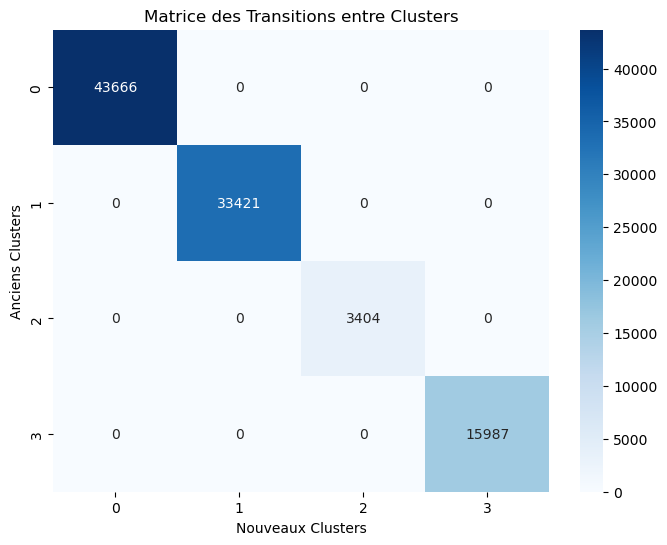

In [11]:
# 1. Charger les données
database_path = 'olist.db'
rfm_data = load_rfm_data(database_path)

# 2. Standardiser les données
rfm_scaled, scaler = standardize_data(rfm_data, ['recency', 'frequency', 'monetary', 'satisfaction'])

# 3. Appliquer K-Means
rfm_data['Cluster'], kmeans = apply_kmeans(rfm_scaled, n_clusters=4)

# 4. Résumé des clusters
cluster_summary = summarize_clusters(rfm_data)
print("Résumé des clusters :")
print(cluster_summary)

# 5. Comparaison avec d'anciens clusters (si disponibles)
# Simuler de nouvelles données
new_rfm_data = rfm_data.copy()  # Par exemple, charger de nouvelles données ici
new_rfm_scaled = scaler.transform(new_rfm_data[['recency', 'frequency', 'monetary', 'satisfaction']])
new_rfm_data['Cluster'] = kmeans.predict(new_rfm_scaled)

# Comparer les clusters
summary, transitions = compare_clusters(rfm_data, new_rfm_data)
print("Résumé des changements :")
print(summary)

# Visualiser les transitions
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(transitions, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice des Transitions entre Clusters")
plt.xlabel("Nouveaux Clusters")
plt.ylabel("Anciens Clusters")
plt.show()